**Real vs Fake Images Detection with ELA(Error Level Analysis) and CNN**

For more information, checkout this repo [https://github.com/agusgun/FakeImageDetector](http://) 

In [1]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download sophatvathana/casia-dataset

^C


The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip /content/casia-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00008_nat10122_11773.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00093_11801.jpg  
  inflating: casia/CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00095_11803.jpg  
  inflating: 

In [5]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [6]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [8]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

Open a real image

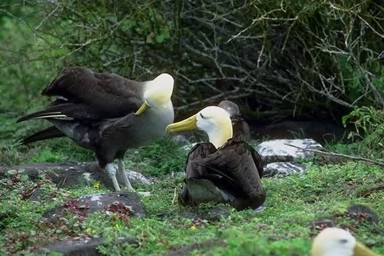

In [11]:
real_image_path = 'casia/CASIA2/Au/Au_ani_00006.jpg'
Image.open(real_image_path)

After converting to ELA image

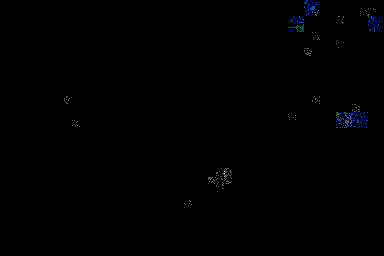

In [12]:
convert_to_ela_image(real_image_path, 90)

Open a fake image

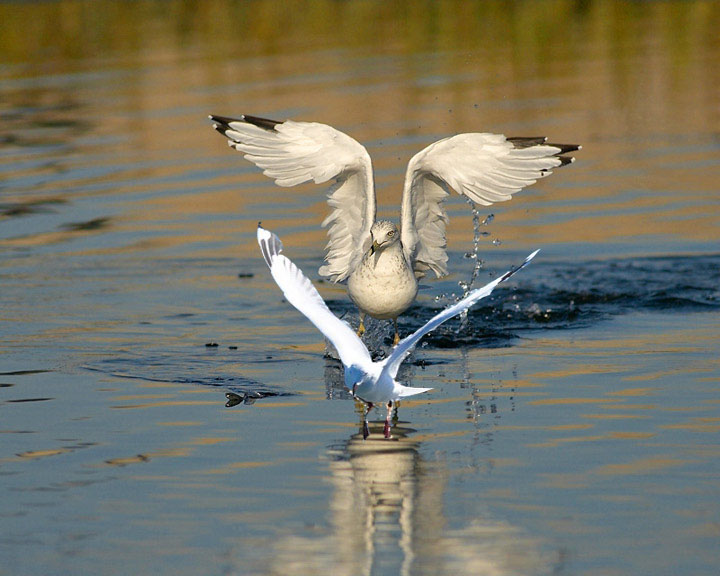

In [15]:
fake_image_path = 'casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10172_ani10166_12450.jpg'
Image.open(fake_image_path)

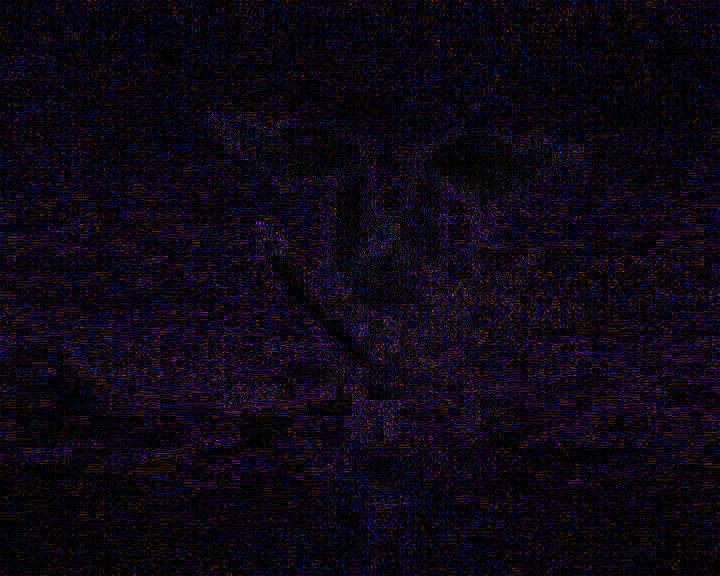

In [16]:
convert_to_ela_image(fake_image_path, 90)

Dataset Preparation

In [17]:
image_size = (128, 128)

In [18]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [19]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Au => Total Images 7354, Take 2100 random images from the list
Tp => Total Images 2064

In [21]:
import random
path = 'CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [22]:
path = 'CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [23]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

Train Test split with 80:20 ratio

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


CNN Model

In [25]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [26]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [27]:
epochs = 30
batch_size = 32


In [28]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [31]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - 23s 114ms/step - loss: 0.5103 - accuracy: 0.7535 - val_loss: 0.3037 - val_accuracy: 0.8992
Epoch 2/30
105/105 [==============================] - 11s 105ms/step - loss: 0.3444 - accuracy: 0.8829 - val_loss: 0.2592 - val_accuracy: 0.9148
Epoch 3/30
105/105 [==============================] - 11s 102ms/step - loss: 0.2945 - accuracy: 0.8979 - val_loss: 0.2216 - val_accuracy: 0.9316
Epoch 4/30
105/105 [==============================] - 11s 106ms/step - loss: 0.2514 - accuracy: 0.9141 - val_loss: 0.1855 - val_accuracy: 0.9424
Epoch 5/30
105/105 [==============================] - 11s 104ms/step - loss: 0.2157 - accuracy: 0.9228 - val_loss: 0.2026 - val_accuracy: 0.9208
Epoch 6/30
105/105 [==============================] - 11s 102ms/step - loss: 0.1891 - accuracy: 0.9301 - val_loss: 0.1483 - val_accuracy: 0.9496
Epoch 7/30
105/105 [==============================] - 11s 103ms/step - loss: 0.1637 - accuracy: 0.9358 - val_loss: 0.1450 - val_ac

In [32]:
model.save('fake_image_model.h5')

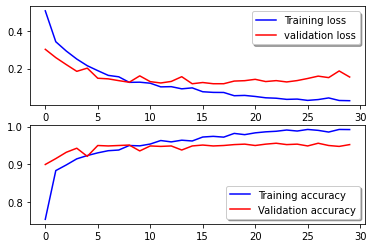

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


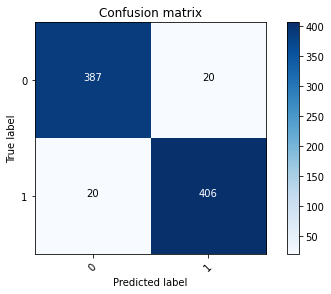

In [35]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

Prediction

In [36]:
class_names = ['fake', 'real'] #[0.1,0.941651]

Class: real Confidence: 100.00


[]

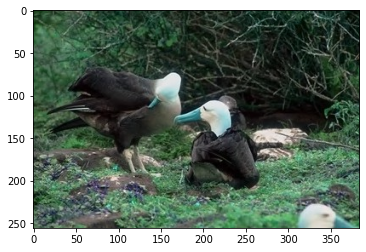

In [51]:
real_image_path = 'casia/CASIA2/Au/Au_ani_00006.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(real_image_path)
plt.imshow(im)
plt.plot()

In [52]:
y_pred

array([[9.915517e-09, 1.000000e+00]], dtype=float32)

Class: fake Confidence: 66.29


[]

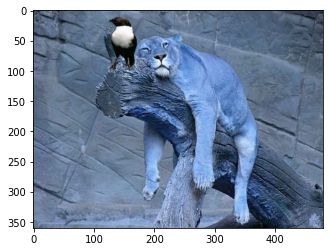

In [53]:
fake_image_path = 'casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10152_ani10175_12490.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

import matplotlib.pyplot as plt
import cv2
im = cv2.imread(fake_image_path)
plt.imshow(im)
plt.plot()

In [54]:
y_pred

array([[0.66285515, 0.33714488]], dtype=float32)